In [1]:
import numpy as np
import src.models.model as NET_FCN  # The net Class
import torch
import src.visualization.visualize as vis
import cv2
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
UseGPU = False
DisplayXYZPointCloud = True  # Show Point cloud
DisplayVesselOpeningOnPointCloud = True  # Add vessel opening to point cloud
MinSize = 600  # Min image size (height or width)
MaxSize = 1000  # Max image sie (height or width)

# define masks and depth maps to predict
MaskClasses = {}
DepthList = ["EmptyVessel_Depth", "ContentDepth", "VesselOpening_Depth"]
MaskList = [
    "VesselMask",
    "ContentMaskClean",
    "VesselOpeningMask",
]  # List of segmentation Masks to predict
depth2Mask = {
    "EmptyVessel_Depth": "VesselMask",
    "ContentDepth": "ContentMaskClean",
    "VesselOpening_Depth": "VesselOpeningMask",
}  # Connect depth map to segmentation mask

# Load model
model = NET_FCN.Net(MaskList=MaskList, DepthList=DepthList)

In [15]:
model_path = r"models/40__29032023-0231.torch"
image_path = "example/Test.jpg"

In [16]:
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()

Net(
  (Encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [17]:
# Load image
image = cv2.imread(image_path)
image = vis.ResizeToMaxSize(image, MaxSize)
image = np.expand_dims(image, axis=0)
print(image.shape)

(1, 535, 800, 3)


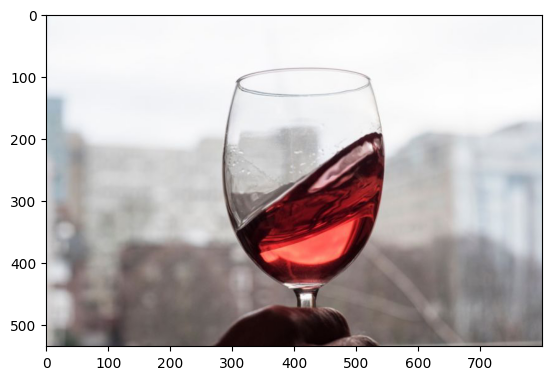

In [18]:
image[0] = cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB)
plt.imshow(image[0])

In [19]:
# Run inference
with torch.no_grad():
    PrdDepth, PrdProb, PrdMask = model.forward(
        Images=image, TrainMode=False, UseGPU=UseGPU
    )  # Run net inference and get prediction

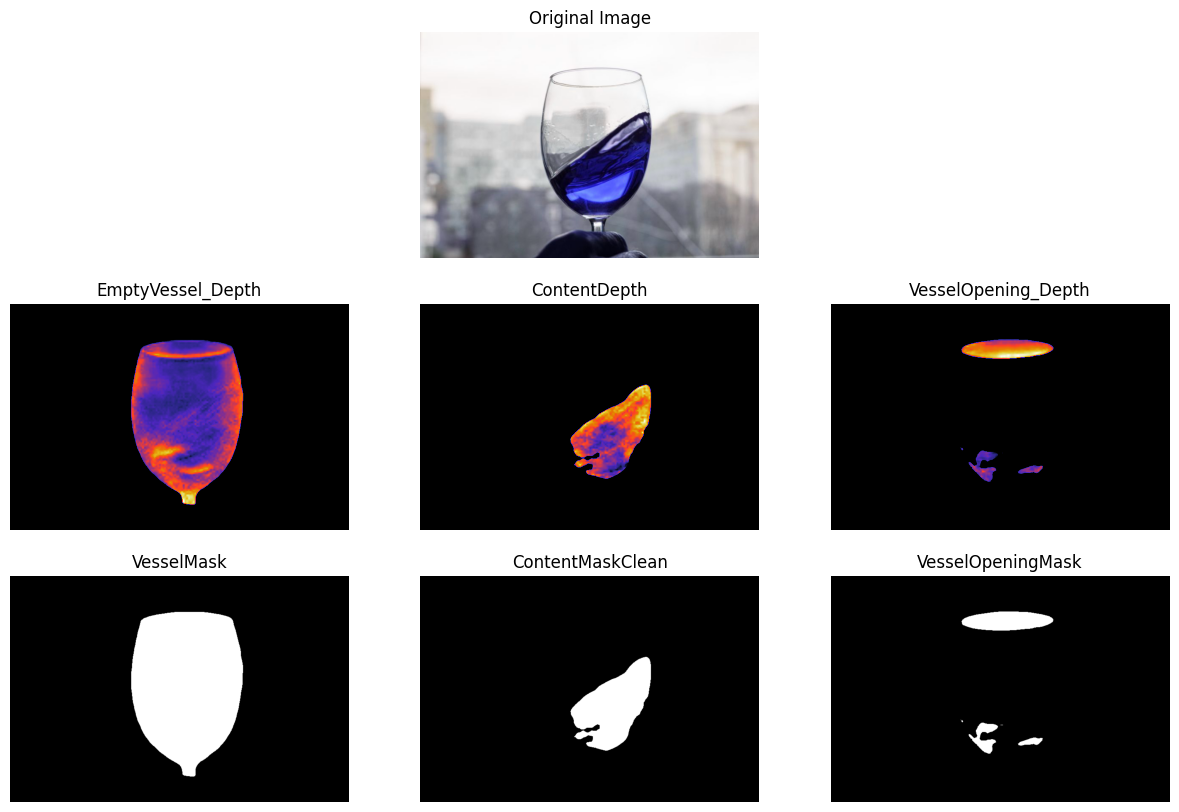

In [21]:
Prd = {}
for nm in PrdDepth:
    # convert to numpy and transpose to (H,W,C)
    Prd[nm] = (PrdDepth[nm].transpose(1, 2).transpose(2, 3)).data.cpu().numpy()
for nm in PrdMask:
    # convert to numpy
    Prd[nm] = (PrdMask[nm]).data.cpu().numpy()

count = 3
# create subplot to show all images in one window
plt.figure(figsize=(15, 10))
# show original image
plt.subplot(3, 3, 2)
image_new = cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB)
plt.imshow(image_new)
plt.title("Original Image")
plt.axis("off")
# loop over all masks and depth maps
for nm in Prd:
    count += 1
    if nm in MaskList:
        # copy mask for visualization
        tmIm = Prd[nm][0].copy()
        # normalize mask to values between 0-255
        if Prd[nm][0].max() > 255 or Prd[nm][0].min() < 0 or np.ndim(Prd[nm][0]) == 2:
            if tmIm.max() > tmIm.min():  #
                tmIm[tmIm > 1000] = 0
                tmIm = tmIm - tmIm.min()
                tmIm = tmIm / tmIm.max() * 255
            if np.ndim(tmIm) == 2:
                tmIm = cv2.cvtColor(tmIm.astype(np.uint8), cv2.COLOR_GRAY2BGR)
        plt.subplot(3, 3, count)
        plt.imshow(tmIm)
        plt.axis("off")
        plt.title(nm)
    else:
        # copy depth map for visualization
        tmIm = Prd[nm].copy()
        # squeeze depth map
        tmIm = tmIm.squeeze()
        if nm in depth2Mask:
            # Remove region out side of the object mask from the depth mask
            tmIm[Prd[depth2Mask[nm]][0] == 0] = 0
            # normalize the rest of the depth map to values between 0-255
            tmIm[Prd[depth2Mask[nm]][0] == 1] += 10
            min = tmIm[Prd[depth2Mask[nm]][0] == 1].min()
            max = tmIm[Prd[depth2Mask[nm]][0] == 1].max()
            tmIm[Prd[depth2Mask[nm]][0] == 1] = tmIm[Prd[depth2Mask[nm]][0] == 1] - min
            max = tmIm[Prd[depth2Mask[nm]][0] == 1].max()
            tmIm[Prd[depth2Mask[nm]][0] == 1] = (
                tmIm[Prd[depth2Mask[nm]][0] == 1] / max * 255
            )

        # visualize depth map
        plt.subplot(3, 3, count)
        plt.imshow(tmIm, cmap="CMRmap")
        # turn off axis
        plt.axis("off")
        plt.title(nm)

In [2]:
import numpy as np

# Load the .npy file
array = np.load("logs/Learning_Rate.npy")

# Print the loaded array
print(array)

1e-05
